In [2]:
# Import libraries
from __future__ import print_function
from torch.nn.functional import sigmoid, relu
from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

seed = np.random.seed(2020)

In [3]:
# Read items, relations and attributes elements
with open('data/sem_items_new.txt','r') as fid:
    names_items = np.array([l.strip() for l in fid.readlines()])
with open('data/sem_relations_new.txt','r') as fid:
    names_relations = np.array([l.strip() for l in fid.readlines()])
with open('data/sem_attributes_new.txt','r') as fid:
    names_attributes = np.array([l.strip() for l in fid.readlines()])
    
nobj = len(names_items)
nrel = len(names_relations)
nattributes = len(names_attributes)

In [4]:
print('List of items:')
print(*names_items,sep=',')
print("\nList of relations:")
print(*names_relations,sep=',')
print("\nList of attributes:")
print(*names_attributes,sep=',')

List of items:
Pine,Oak,Rose,Daisy,Robin,Canary,Sunfish,Salmon,Turtle,Crocodile

List of relations:
ISA,Is,Can,Has

List of attributes:
Living thing,Plant,Animal,Tree,Flower,Bird,Fish,Reptile,Pine,Oak,Rose,Daisy,Robin,Canary,Sunfish,Salmon,Turtle,Crocodile,Pretty,Big,Living,Green,Red,Yellow,Slow,Grow,Move,Swim,Fly,Sing,Skin,Roots,Leaves,Bark,Branch,Petals,Wings,Feathers,Gills,Scales,Backbone,Produce Eggs,Shell


In [6]:
# Reads training data
training_data = np.loadtxt('data/sem_data_new.txt')
input_pats    = training_data[:,:nobj+nrel]
input_pats    = torch.tensor(input_pats,dtype=torch.float)
output_pats   = training_data[:,nobj+nrel:]
output_pats   = torch.tensor(output_pats,dtype=torch.float)
training_set_size = input_pats.shape[0]

In [7]:
#Printing one random element of the data
item_display_ind = 35 # can change, just represents index of input data to show as example.
input_v = input_pats[item_display_ind,:].numpy().astype('bool')
output_v = output_pats[item_display_ind,:].numpy().astype('bool')
print('Example input pattern:')
print(input_v.astype('int'))
print('Example output pattern:')
print(output_v.astype('int'))
print("")
print("Which encodes...")
print('Item ',end='')
print(names_items[input_v[:nobj]])
print('Relation ',end='')
print(names_relations[input_v[nobj:]])
print('Attributes ',end='')
print(names_attributes[output_v])

Example input pattern:
[0 0 0 0 0 0 0 0 1 0 0 0 0 1]
Example output pattern:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 1]

Which encodes...
Item ['Turtle']
Relation ['Has']
Attributes ['Skin' 'Backbone' 'Shell']


In [37]:
class Net(nn.Module):
    def __init__(self, n_items, n_relations, n_attributes, rep_layer_size, hidden_layer_size):
        super(Net, self).__init__()
        # Input
        #  rep_size : number of hidden units in "Representation Layer"
        #  hidden_Size : number of hidden units in "Hidden Layer"
        #
        self.n_items = n_items # input to rep
        self.n_relations = n_relations # input to hidden
        self.n_attributes = n_attributes # output        
        
        self.i2rep = nn.Linear(self.n_items, rep_layer_size)
        self.all2h = nn.Linear(rep_layer_size+self.n_relations, hidden_layer_size)
        self.h2o   = nn.Linear(hidden_layer_size, self.n_attributes)
        
    def forward(self, x):
        # Defines forward pass for the network on input patterns x
        #
        # Input can take these two forms:
        #
        #   x: [nobj+nrel 1D Tensor], which is a single input pattern as a 1D tensor
        #      (containing both object and relation 1-hot identifier) (batch size is B=1)
        #   OR
        #   x : [B x (nobj+nrel) Tensor], which is a batch of B input patterns (one for each row)
        #
        # Output
        #   output [B x nattribute Tensor], which is the output pattern for each input pattern B on the Attribute Layer
        #   hidden [B x hidden_size Tensor], which are activations in the Hidden Layer
        #   rep [B x rep_size Tensor], which are the activations in the Representation LAyer
        x      = x.view(-1, self.n_items+self.n_relations) # reshape as size [B x (nobj+nrel) Tensor] if B=1
        x_item = x[:,:self.n_items] # input to Item Layer [B x nobj Tensor]
        x_rel  = x[:,self.n_items:] # input to Relation Layer [B x nrel Tensor]
        
        rep             = relu(self.i2rep(x_item))
        input_to_hidden = torch.cat((rep,x_rel), dim=1)
        hidden          = relu(self.all2h(input_to_hidden))
        output          = torch.sigmoid(self.h2o(hidden))
                
        return output, hidden, rep
    

In [26]:
class EarlyStop() :
    
    def __init__(self,patience=10,epsilon=.0001) :
        
        self.allowed = 0
        self.patience = patience
        self.epsilon = epsilon
        self.early_stop = False
        self.state = {}
        self.min_loss = 9e10
        
    def step(self,loss,model) :
        
        if abs(loss - self.min_loss) < self.epsilon :
            print('Incremental Loss is less than epsilon value...')
            self.early_stop = True
        if loss > self.min_loss :
            self.min_loss += 1
        else :
            self.min_loss = loss
            self.w = model.state_dict()
            self.allowed = 0 # reset if the loss decreased an acceptable amount
            
        if self.allowed == self.patience :
            print('Loss has not decreased for {} epochs'.format(self.patience))
            self.early_stop = True
            

In [38]:
def train(mynet, input_pats, output_pats, criterion, optimizer):
    # Input
    #  mynet : Net class object
    error_epoch = 0
    mynet.train()
    training_set_size = input_pats.shape[0]
    perm = np.random.permutation(training_set_size)
    for p in perm: # iterate through input patterns in random order
        mynet.zero_grad() # reset gradient
        output, hidden, rep = mynet(input_pats[p,:]) # forward pass
        target = output_pats[p,:] 
        target = target.view(1,-1) # Get target into expected [1,_] format
        loss = criterion(output, target) # compute loss
        loss.backward() # compute gradient 
        optimizer.step() # update network parameters
        error_epoch += loss.item()
    
    return error_epoch / float(training_set_size)

In [50]:
def plot_opt1(rep_layer) :
    
    stacked = np.dstack(rep_layer)
    fig,axes = plt.subplots(nrows=4,ncols=2,sharex=True,sharey=False,figsize=(15,10),squeeze=False)
    fig.suptitle('Representation Layer Weights per epoch',size=15)

    row_count,col_count = 0,0

    for j in range(8) :
        axes[row_count,col_count].set_title('Rep Node {}'.format(j))
        for i,name in enumerate(names_items) :
            axes[row_count,col_count].plot(range(n_epochs),stacked[i][j])
        if col_count == 1 :
            row_count+=1
            col_count = 0
        else :
            col_count += 1
    fig.legend(names_items,ncol=10,loc='lower center',fontsize=10)
    plt.show()

def plot_opt2(rep_layer) :
    
    stacked = np.dstack(rep_layer)
    fig,axes = plt.subplots(nrows=5,ncols=2,sharex=True,sharey=False,figsize=(15,10),squeeze=False)
    fig.suptitle('Representation Layer Weights per epoch',size=15)

    row_count,col_count = 0,0

    for i,name in enumerate(names_items) :
        axes[row_count,col_count].set_title(name)
        for j in range(8) :
            axes[row_count,col_count].plot(range(n_epochs),stacked[i][j])
        if col_count == 1 :
            row_count+=1
            col_count = 0
        else :
            col_count += 1
    fig.legend(['Rep_Node_'+str(i) for i in range(8)],ncol=10,loc='lower center',fontsize=10)
    plt.show()

def plot_opt3(rep_layer,num_plots=3):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using bar graphs
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    epochs_plot = [i if i < len(rep_layer) else i-1 for 
                   i in list(map(int,np.linspace(0,len(rep_layer),num_plots)))]
    stacked = np.dstack(rep_layer)    
    mx,mn = stacked.max(),stacked.min()
    count = 1
    plt.figure(1,figsize=(15,10))
    for i in range(nobj):
        for d in epochs_plot:
            plt.subplot(nobj, num_plots, count)
            rep = stacked[i,:,d]
            plt.bar(range(rep.size),rep)
            plt.ylim([mn,mx])
            plt.xticks([])
            plt.yticks([])        
            if d==0:
                plt.ylabel(names_items[i])
            if i==0:
                plt.title("epoch " + str(d))
            count += 1
    plt.show()
    
def plot_rep(plot_option,rep_layer,num_plots=3) :
    
    if plot_option==1 :
        plot_opt1(rep_layer)
    elif plot_option==2 :
        plot_opt2(rep_layer)
    elif plot_option==3:
        plot_opt3(rep_layer,num_plots)
    else:
        raise ValueError('Invalid option #')

def plot_dendo(rep_layer,num_plots=3):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using hierarchical clustering
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    epochs_plot = [i if i < len(rep_layer) else i-1 for 
                   i in list(map(int,np.linspace(0,len(rep_layer),num_plots)))]
    mv = 0
    plt.figure(num_plots,figsize=(5,10))
    for i,d in enumerate(epochs_plot) :
        linked = linkage(rep_layer[d],'single')
        plt.subplot(num_plots,1,i+1)
        plt.tight_layout()
        dendrogram(linked, labels=names_items, color_threshold=0)
        if i == 0 :
            plt.title("Dendrogram Relationships per epoch \nepoch " + str(d))
        else :
            plt.title("epoch " + str(d))
        plt.xticks(rotation=45,ha='right')
    plt.show()
    
def plot_loss(err) :
    
    plt.figure(figsize=(10,5))
    plt.plot(range(n_epochs),err)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch',fontsize=15)
    plt.show()

In [73]:
# Network Configuration
learning_rate = 0.01
mynet     = Net(nobj, nrel, nattributes, rep_layer_size=8, hidden_layer_size=15) 
optimizer = torch.optim.SGD(mynet.parameters(), lr=learning_rate) # stochastic gradient descent
criterion = nn.BCELoss() #nn.MSELoss() # mean squared error loss function

# Training Setup
errors          = []
rep_layers      = []
n_epochs        = 3000
use_early_stop  = True
early_stop      = EarlyStop(epsilon=1e-8)

# Training
for epoch in range(n_epochs):    
    
    loss = train(mynet, input_pats, output_pats, criterion, optimizer)
    errors.append(loss)    
    
    mynet.eval()
    rep_layer = mynet(torch.eye(nobj,nobj+nrel))[2].detach().numpy() #mynet.get_rep_layer_activations() 
    rep_layers.append(rep_layer)
    
    if use_early_stop:
        early_stop.step(errors[-1],mynet)
        if early_stop.early_stop :
            print('Early Stopping... Epoch: {}  Loss: {}'.format(epoch,errors[-1]))
            mynet.load_state_dict(early_stop.w) # in the case of increase of loss, pull previous state.
            n_epochs = epoch+1
            break          
            
    if (epoch % 250 == 0) or (epoch == n_epochs - 1):
        print('Epoch: {}  Loss: {}'.format(epoch,errors[-1]))
        

Epoch: 0  Loss: 0.6796859204769135
Epoch: 250  Loss: 0.22422955222427846
Epoch: 500  Loss: 0.20713217724114658
Epoch: 750  Loss: 0.17633415972813965
Epoch: 1000  Loss: 0.14791174931451678
Epoch: 1250  Loss: 0.13088138028979301
Epoch: 1500  Loss: 0.12083964347839356
Epoch: 1750  Loss: 0.11334548774175346
Epoch: 2000  Loss: 0.10504019591026008
Epoch: 2250  Loss: 0.0941085762809962
Epoch: 2500  Loss: 0.08299364205449819
Epoch: 2750  Loss: 0.07487751839216798
Epoch: 2999  Loss: 0.06944873909233137


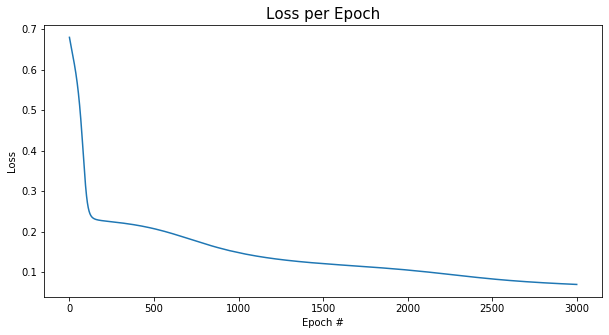

In [74]:
plot_loss(errors)

2 PCs explain 87.96% of variance
2 PCs explain 98.91% of variance
2 PCs explain 98.9% of variance
2 PCs explain 98.86% of variance
2 PCs explain 98.8% of variance
2 PCs explain 98.67% of variance
2 PCs explain 98.53% of variance
2 PCs explain 98.4% of variance
2 PCs explain 98.21% of variance
2 PCs explain 97.88% of variance


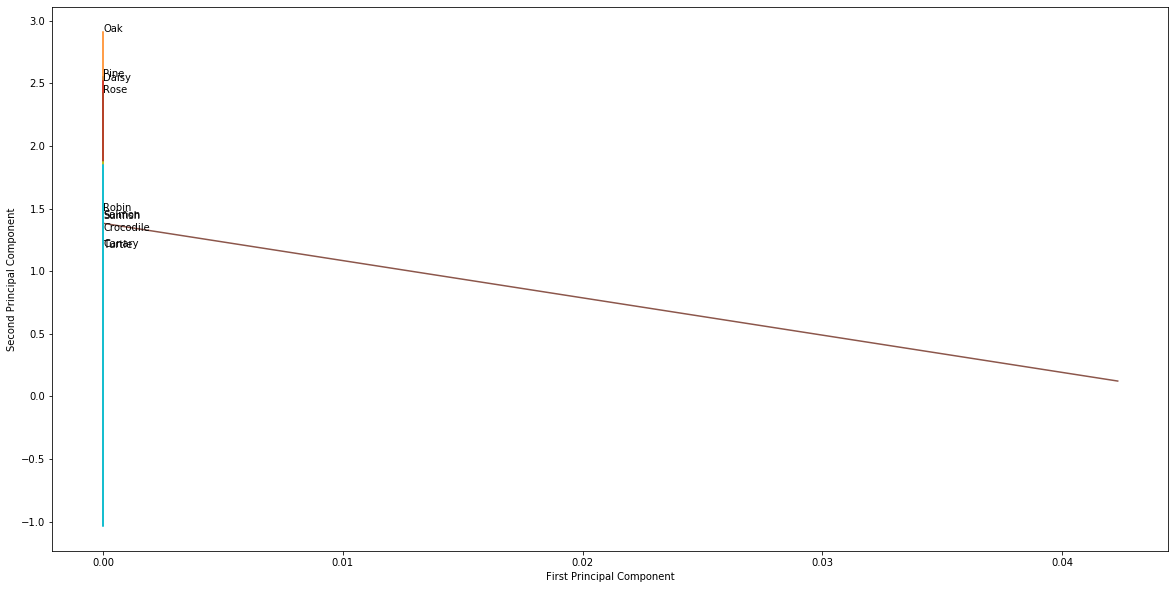

In [76]:
## The following observes principal components for the representation layer drawn out at different points in
## time of training. Essentially a multi-variate visualization to seeing differentiation through training.

def plot_pca(rep_layers, names_items):
    inds_look = np.linspace(0,len(rep_layers),10)
    inds_look[-1] = inds_look[-1]-1
    inds_look = list(map(int,inds_look))

    projections = []

    for ind in inds_look:
        mat = rep_layers[ind]
        u,s,v = np.linalg.svd(mat.T.dot(mat))
        projection = mat.dot(v[:,:2])
        print('2 PCs explain {}% of variance'.format(round(100*(np.cumsum(s) / np.sum(s))[1],ndigits=2)))
        projections.append(projection)

    plt.figure(figsize=(20,10))
    for i in range(len(names_items)) :
        to_plot = np.array(projections)[:,i]
        plt.plot(to_plot[:,0],to_plot[:,1])
        plt.annotate(names_items[i],(to_plot[-1,0],to_plot[-1,1]))
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()
    
plot_pca(rep_layers, names_items)

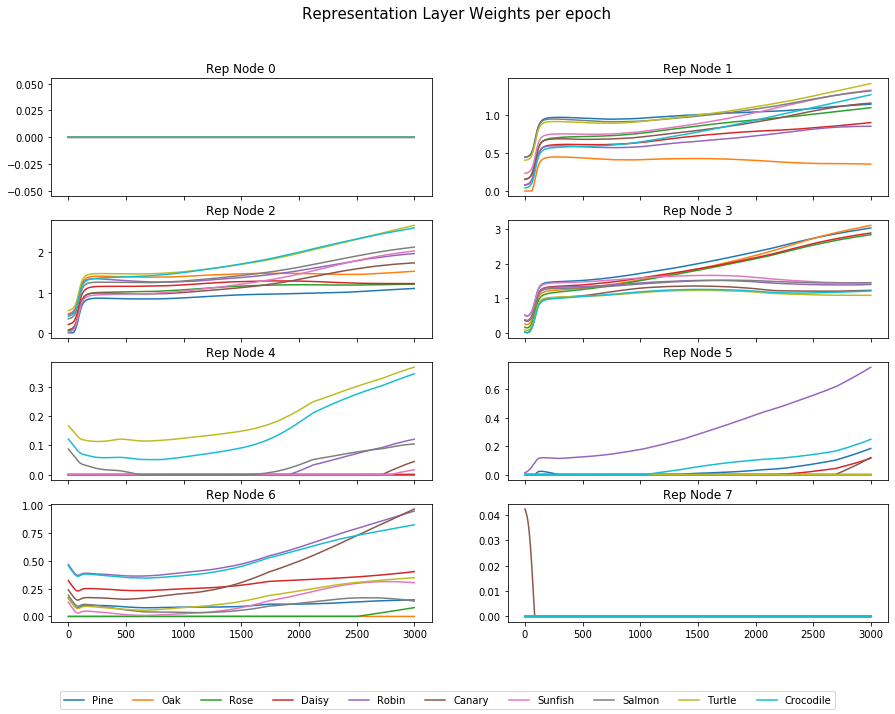

In [77]:
plot_rep(plot_option=1,rep_layer=rep_layers) # There are 3 plot options I created.

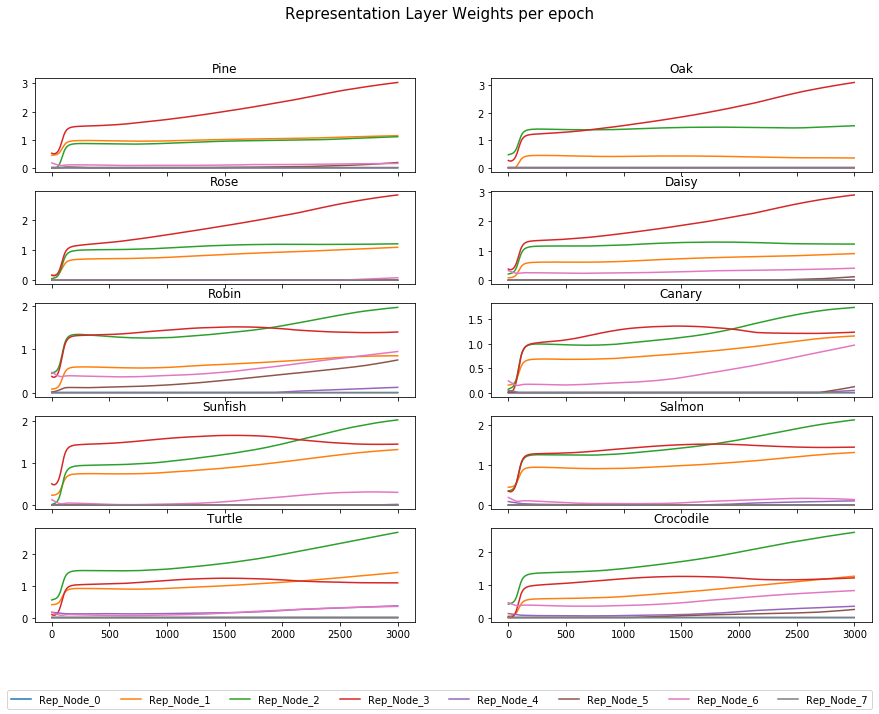

In [78]:
plot_rep(plot_option=2,rep_layer=rep_layers) # There are 3 plot options I created.

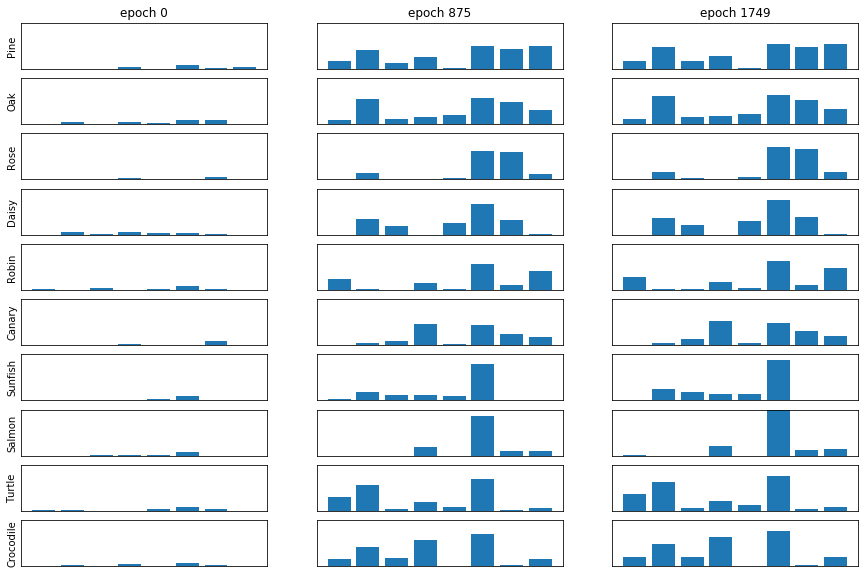

In [65]:
plot_rep(plot_option=3,rep_layer=rep_layers) # There are 3 plot options I created.

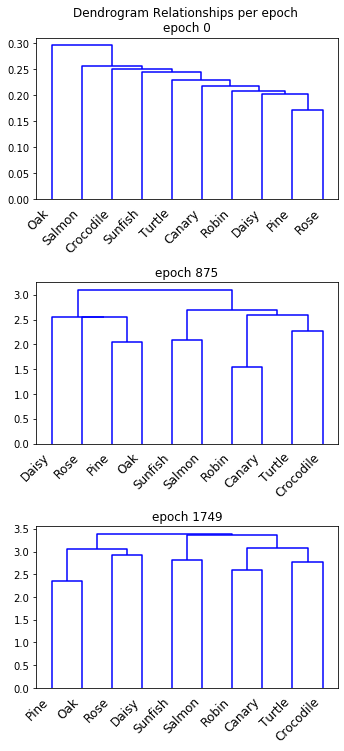

In [44]:
plot_dendo(rep_layers)

In [67]:
torch.save({'epoch'               : n_epochs,
            'model_state_dict'    : mynet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losses' : errors,
            'rep_layer' : rep_layers},
            'trained_model.pt')